In [21]:
import pathlib
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#데이터셋은 UCI 머신 러닝 저장소에서 다운로드
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
print(dataset_path)
#미국에서 연비가 1 mpg라면 1 갤런의 연료로 1 마일을 갈 수 있다는 뜻 #연비가 맨 앞에 표시됨
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
# na_values 데이터셋 파일에 다양한 모양, 기호의 결측값이 존재. 결측값 기호를 표기해 주어
# 이들 특정 기호를 pandas가 결측값으로 인식할 수 있도록 해줌. 예를 들어 문서의 숫자형 변수 # 에 결측값이 '?'라는 표시로 되어다면, 이를 pandas DataFrame으로 불러읽어들였을 경우 float # 나 int로 인식되어 불러오는 것이 아니라 string으로 인식해서 '?'를 결측값이 아니라 문자형 # 으로 불러 옴
# comment : 주석으로 분류되어 파싱하지 않을 문자 혹은 문자열
# skipinitialspace : True일 때, delimiter 바로 뒤에 오는 공백은 무시.기본값은 False. 
raw_dataset = pd.read_csv(dataset_path, names=column_names,na_values = "?", comment='\t',
                        sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
print(dataset.tail())

/Users/daeseong/.keras/datasets/auto-mpg.data
      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1  


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

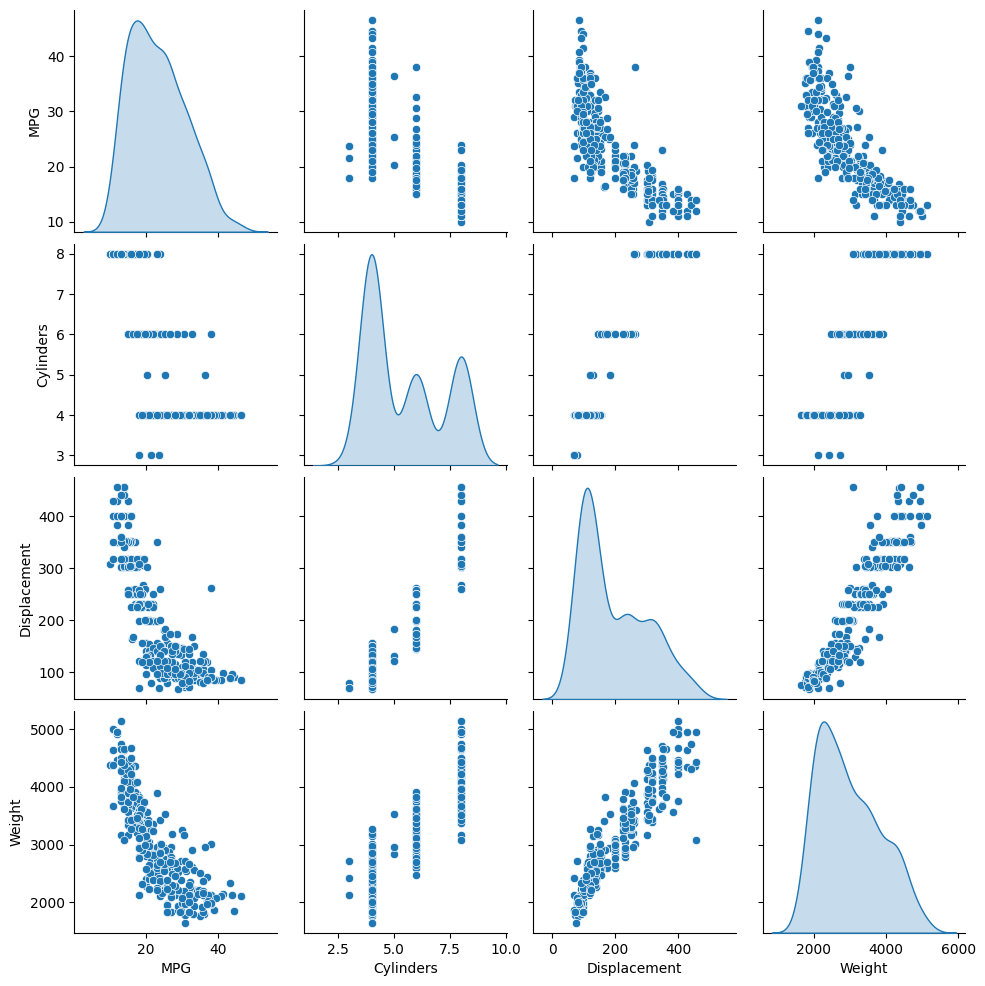

In [22]:
'''
DataFrame을 가지고 분석을 진행하다 보면 대부분의 경우 결측값(missing value)이 문제임 데이터가 원래 수집 혹은 측정이 안되었을 수도 있고, 다수의 DataFrame을 서로 병합하는 과정에서 결측값이 생길 수도 있으며, index를 재설정(reindex)하는 경우에도 결측값이 발생. 이처럼 다양한 이유로 인해서 생기는 결측값은 분석 오류가 발생시키거나 혹은 왜곡시킬 위험이 있으므로 분석할 DataFrame을 생성했으면 결측값(missing value)이 있는지 여부에 대해서 꼭 확인하고 조치하여야 함
'''
#칼럼별 결측값 개수 구하기 : df.isnull().sum()
print(dataset.isnull().sum())
#문제를 간단하게 만들기 위해서 누락된 행을 삭제
dataset = dataset.dropna()
#항목중 Origin이 원산지인데 수치형이 아니고 범주형이므로 원-핫 인코딩(one-hot encoding)으로 변환 #1,2,3을1.00.00.0/0.01.00.0/0.00.01.0 형태로변환
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0 
dataset['Japan'] = (origin == 3)*1.0 
dataset.tail()
#학습셋 검증셋 분리
train_dataset = dataset.sample(frac=0.8,random_state=0) 
test_dataset = dataset.drop(train_dataset.index)
#data 확인(훈련 세트에서 몇 개의 열을 선택해 산점도 행렬을 작성)
#
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [25]:
#통계적인 확인
#describe() 함수를 사용하면 수치형 변수들만을 기준으로 카운트,평균,표준편차, #최소/최댓값, 4분위 수를 기준으로 25%, 50%, 75%에 해당하는 값들을 테이블로 #출력해준다
#데이터의 개수(count), 데이터의 평균값(mean), 표준 편차(std), 최솟값(min), #4분위수(25%, 50%, 75%), 그리고 최댓값(max)들의 정보를 알 수 있음 
train_stats = train_dataset.describe()
train_stats.pop("MPG")
#그룹 별 기술통계량 - 옆으로 길게 표시
train_stats = train_stats.transpose()
print(train_stats)
#특성에서 타깃 값 또는 "레이블"을 분리. 이 레이블을 예측하기 위해 모델을 훈련시킴
train_labels = train_dataset.pop('MPG') 
test_labels = test_dataset.pop('MPG')
#data 정규화 함수 정의
def norm(x):
    #(X - 평균) / 표준편차 - Z-Score Normalization (Z-점수 정규화) 
    return (x - train_stats['mean']) / train_stats['std']


# train_dataset과 test_dataset을 분류
normed_train_data = norm(train_dataset) 
normed_test_data = norm(test_dataset)

              count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
USA              1.00     1.0  
Europe       

In [26]:
#모델 만들기
model = tf.keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())])) 
                             
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1))
optimizer = tf.keras.optimizers.RMSprop(0.001)
# 측정항목 함수는 loss function와 비슷하지만, 측정항목을 평가한 결과는 모델을 학습시키는데 #사용되지 않는다는 점에서 다름. MSE(mean squared error)와 MAE(mean absolute error)를 평가 
model.compile(loss='mse',
                optimizer=optimizer, 
                metrics=['mae', 'mse'])
#Model을 확인해 봄 가중치와 바이어스가 초기값(랜덤값)인 모델
example_batch = normed_train_data[:10] 
example_result = model.predict(example_batch) 
print(example_result)
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')
EPOCHS = 1000
#입력값을 필히 정규화된 값으로 넣어줘야 함
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
    callbacks=[PrintDot()])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[[0.21887074]
 [0.26650792]
 [0.34677362]
 [0.15128322]
 [0.26945466]
 [0.3136319 ]
 [0.32562774]
 [0.26013884]
 [0.15261725]
 [0.35183483]]

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............

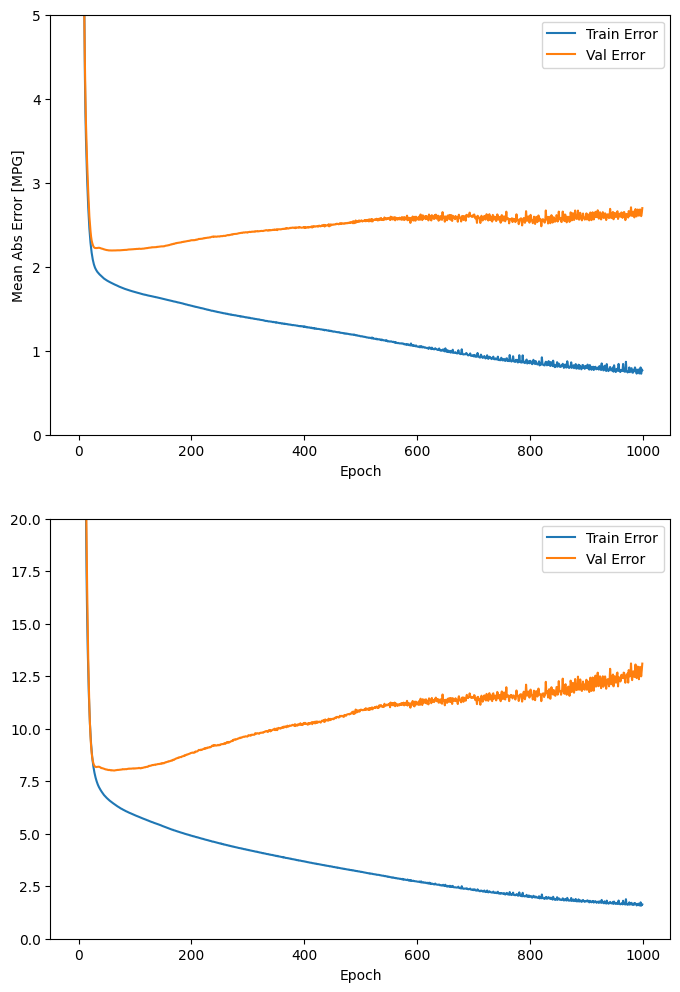

In [28]:
import matplotlib.pyplot as plt
def plot_history(history):
    hist = pd.DataFrame(history.history) 
    hist['epoch'] = history.epoch 
    plt.figure(figsize=(8,12))
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],label='Train Error') 
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error') 
    plt.ylim([0,5]) #y축 범위 설정
    #그래프 영역에 범례(legend)를 나타내기 위해서는 우선 plot() 함수에 label 문자열을 지정 # 하고, matplotlib.pyplot 모듈의 legend() 함수를 호출.
    plt.legend()
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    #달러기호($) 사이에 위치하는 TeXt 마크업 표현을 통해 Matplotlib에서 수학적 표현을 사용 plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
    plt.ylim([0,20]) #y축 범위 설정
    plt.legend()
    plt.show() 
plot_history(history)


............

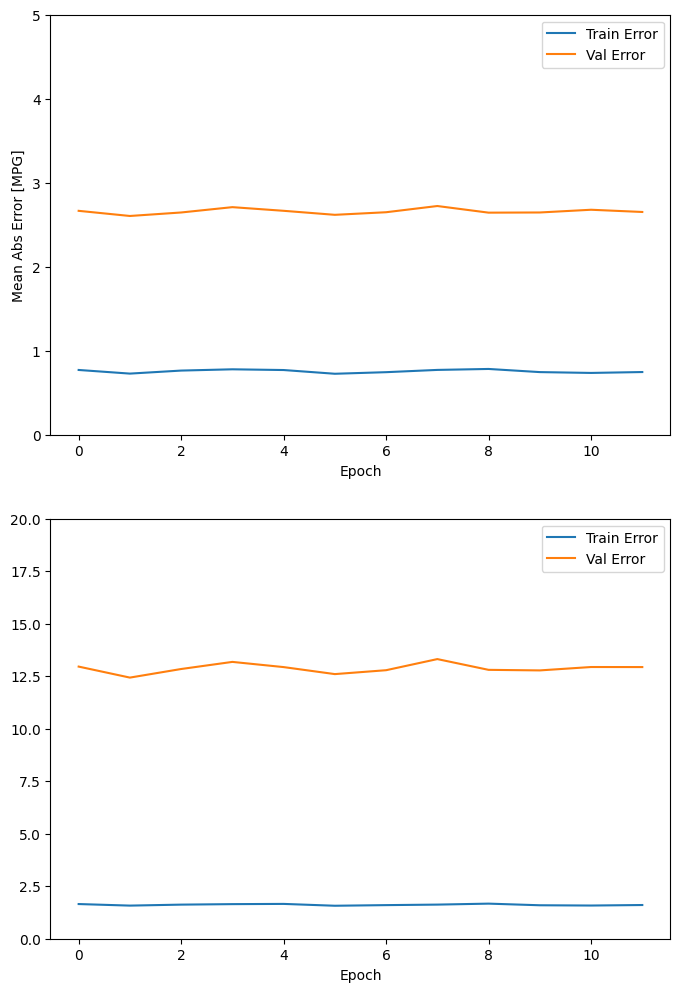

In [29]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
실제 최소 = 9.689725, 실제 최대 = 41.341087, 오차 평균 = 2.376193
예상 최소 = 9.000000, 예상 최대 = 44.300000


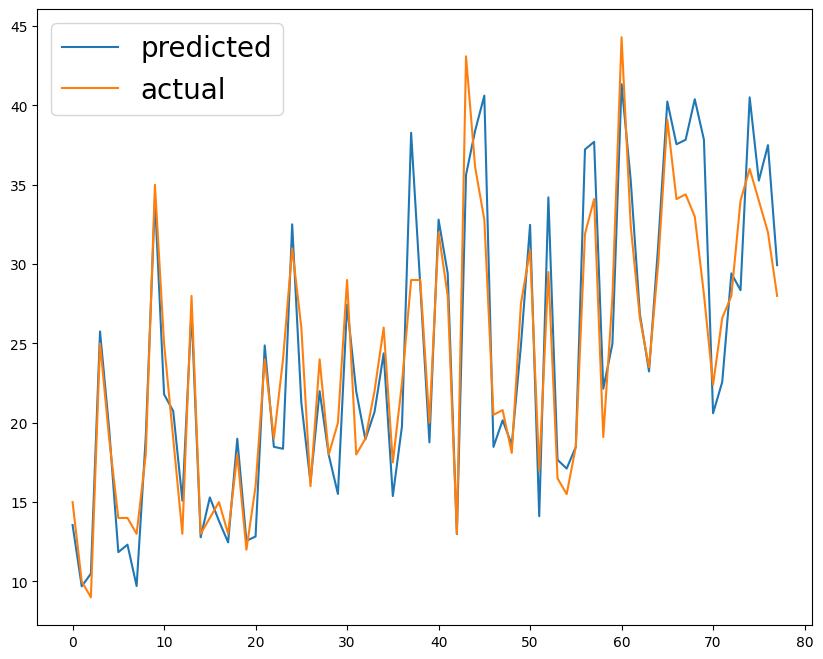

In [30]:
# 예측값과 실제값을 비교하여 그래프로 확인
Y_prediction = model.predict(normed_test_data).flatten() 
plt.figure(figsize=(10,8))
plt.plot(Y_prediction, label = "predicted") 
plt.plot(test_labels.values, label = "actual") 
plt.legend(prop={'size' : 20})
#예측값과 실제값 오차 평균을 측정
avr = abs(Y_prediction - test_labels).mean()
print('실제 최소 = %f, 실제 최대 = %f, 오차 평균 = %f'%(min(Y_prediction),max(Y_prediction),avr)) 
print('예상 최소 = %f, 예상 최대 = %f'%(min(test_labels),max(test_labels)))